In [1]:
from utils import *
from speedup import *

---
# Reference file

In [2]:
with open("/v/volumes/nanopore/ref/p300_ID3.fasta", 'r') as file:
    p300_ID3_ref = file.read().split('\n')[1]
p300_ID3_ref = np.array(list(p300_ID3_ref))
print(f'Length of ref sequence: {len(p300_ID3_ref)}')
p300_ID3_ref

Length of ref sequence: 1164


array(['A', 'A', 'C', ..., 'C', 'A', 'G'], dtype='<U1')

In [3]:
find_loneliest_bases_in_seq(p300_ID3_ref, verbose=True, only_nth=0)

The position of the loneliest base 'T': 692
Distances between the neighborhood: [ 6 15 20  1]
The subsequence:
 ['T' 'C' 'C' 'A' 'A' 'G' 'G' 'C' 'A' 'G' 'A' 'C' 'A' 'C' 'C' 'T' 'A' 'C'
 'A' 'C' 'C' 'A' 'C' 'C' 'A' 'A' 'C' 'A' 'A' 'C' 'A' 'C' 'A' 'A' 'C' 'T']


---
# Thymine dataset

```python
    T_sam_data = read_sam(sorted(glob("/v/projects/nanopore/balazs/data/thymine_0421/*0.sam")),
                          min_length=len(p300_ID3_ref)*0.8,
                          max_length=len(p300_ID3_ref)*1.2, 
                          min_MAPQ=60,
                          max_insertion=7, # connected sequence
                          max_deletion=7, # connected sequence
                          max_indel_frequency=0.4,
                          verbose=True
                         )
    path_to_Thymine_fast5 = '/v/projects/nanopore/agnes/signal_visualization/data/timin0421/workspace/'

Loading data: 100%|██████████| 7/7 [00:11<00:00,  1.61s/it]
Number of reads stored: 17420

```

```python
    # thymine forward strands
    T_forward_strands = search_in_data(T_sam_data, "sam_flag",  0, only_first_match=False) 
    thymine_fwd_strd = get_raw_signal_with_bases(T_forward_strands, path_to_Thymine_fast5, reference_sequence=p300_ID3_ref)
    with open("/v/projects/nanopore/balazs/data/thymine_0421_fwd_strand.pkl", "wb") as f:
        pickle.dump(thymine_fwd_strd, f)

Processing data: 100%|██████████| 11167/11167 [02:54<00:00, 63.84it/s]
```

```python
    # thymine reverse strands
    T_reverse_strands = search_in_data(T_sam_data, "sam_flag", 16, only_first_match=False)
    thymine_rvs_strd = get_raw_signal_with_bases(T_reverse_strands, path_to_Thymine_fast5, reference_sequence=p300_ID3_ref)
    with open("/v/projects/nanopore/balazs/data/thymine_0421_rvs_strand.pkl", "wb") as f:
        pickle.dump(thymine_rvs_strd, f)

Processing data: 100%|██████████| 6253/6253 [01:52<00:00, 55.72it/s]
```

In [4]:
with open("/v/projects/nanopore/balazs/data/thymine_0421_fwd_strand.pkl", "rb") as f:
    thymine_fwd_strd = pickle.load(f)

In [5]:
with open("/v/projects/nanopore/balazs/data/thymine_0421_rvs_strand.pkl", "rb") as f:
    thymine_rvs_strd = pickle.load(f)

---
# Uracil dataset

```python
    np.random.seed(137) # there are too much files
    read_paths = np.random.choice(glob("/v/projects/nanopore/balazs/data/uracil_0504/*0.sam"), 15)
    U_sam_data = read_sam(sorted(read_paths),
                          min_length=len(p300_ID3_ref)*0.8,
                          max_length=len(p300_ID3_ref)*1.2, 
                          min_MAPQ=60,
                          max_insertion=4, # connected sequence
                          max_deletion=4, # connected sequence
                          max_indel_frequency=0.1,
                          verbose=True
                         )
    path_to_Uracil_fast5 = '/v/projects/nanopore/agnes/signal_visualization/uracil0504/guppy/workspace/'
    
Loading data: 100%|██████████| 15/15 [00:34<00:00,  2.27s/it]
Number of reads stored: 21457

```

```python
    # uracil forward strands
    U_forward_strands = search_in_data(U_sam_data, "sam_flag",  0, only_first_match=False)
    uracil_fwd_strd = get_raw_signal_with_bases(U_forward_strands, path_to_Uracil_fast5, reference_sequence=p300_ID3_ref)
    with open("/v/projects/nanopore/balazs/data/uracil_0504_fwd_strand.pkl", "wb") as f:
        pickle.dump(uracil_fwd_strd, f)

Processing data: 100%|██████████| 10563/10563 [04:08<00:00, 42.52it/s]
```

```python
    # uracil reverse strands
    U_reverse_strands = search_in_data(U_sam_data, "sam_flag", 16, only_first_match=False)
    uracil_rvs_strd = get_raw_signal_with_bases(U_reverse_strands, path_to_Uracil_fast5, reference_sequence=p300_ID3_ref)[:10500]
    # saved only 10500 reads due to memory issue
    with open("/v/projects/nanopore/balazs/data/uracil_0504_rvs_strand.pkl", "wb") as f:
        pickle.dump(uracil_rvs_strd, f)
        
Processing data: 100%|██████████| 10894/10894 [04:03<00:00, 44.72it/s]
```

In [6]:
with open("/v/projects/nanopore/balazs/data/uracil_0504_fwd_strand.pkl", "rb") as f:
    uracil_fwd_strd = pickle.load(f)

In [7]:
with open("/v/projects/nanopore/balazs/data/uracil_0504_rvs_strand.pkl", "rb") as f:
    uracil_rvs_strd = pickle.load(f)

---
# Violin plot in the neighborhood of a lonely T/U
### forward 

In [8]:
searched_position = find_loneliest_bases_in_seq(p300_ID3_ref, only_nth=0)
searched_position 

692

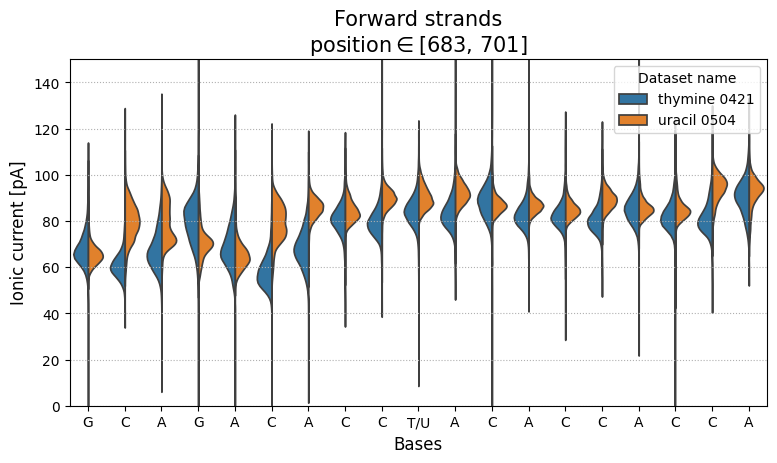

In [9]:
N_left, N_right = 9, 9 # number of left and right neighbors

data_T_fwd = create_df_to_violin_plot(thymine_fwd_strd, 'thymine 0421',
                                      N_left, N_right, searched_position)
data_U_fwd = create_df_to_violin_plot(uracil_fwd_strd, 'uracil 0504', 
                                      N_left, N_right, searched_position, )

fwd_violin_df = pd.concat([data_T_fwd, data_U_fwd], ignore_index=True)

plt.figure(figsize=(9, 4.5))
plt.grid(ls='dotted', axis='y')
sns.violinplot(data=fwd_violin_df, x="Bases", y="IonicCurrent", hue="Dataset name", split=True, density_norm="width", inner=None)
plt.xlabel("Bases", fontsize=FS)
plt.ylabel("Ionic current [pA]", fontsize=FS)
plt.title("Forward strands\nposition"+r"$\in$"+f"[{searched_position-N_left}, {searched_position+N_right}]", fontsize=FS+3)
plt.ylim(0, 150)
labels = p300_ID3_ref[searched_position - N_left: searched_position + N_right + 1]
plt.xticks(ticks=np.arange(N_left+N_right+1), labels=np.where(labels=='T', 'T/U', labels))
plt.savefig(f'figures/violin_fwd_pos={searched_position}_Nleft={N_left}_Nright={N_right}.pdf', bbox_inches='tight')
plt.show()

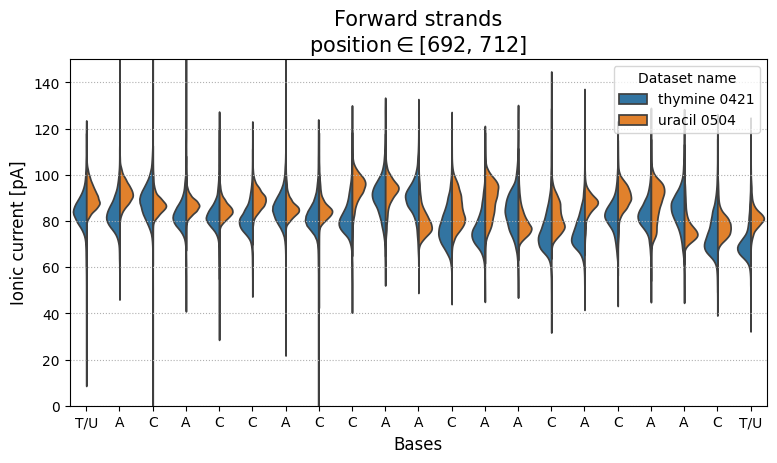

In [10]:
N_left, N_right = 0, 20 # number of left and right neighbors

data_T_fwd = create_df_to_violin_plot(thymine_fwd_strd, 'thymine 0421',
                                      N_left, N_right, searched_position)
data_U_fwd = create_df_to_violin_plot(uracil_fwd_strd, 'uracil 0504', 
                                      N_left, N_right, searched_position, )

fwd_violin_df = pd.concat([data_T_fwd, data_U_fwd], ignore_index=True)

plt.figure(figsize=(9, 4.5))
plt.grid(ls='dotted', axis='y')
sns.violinplot(data=fwd_violin_df, x="Bases", y="IonicCurrent", hue="Dataset name", split=True, density_norm="width", inner=None)
plt.xlabel("Bases", fontsize=FS)
plt.ylabel("Ionic current [pA]", fontsize=FS)
plt.title("Forward strands\nposition"+r"$\in$"+f"[{searched_position-N_left}, {searched_position+N_right}]", fontsize=FS+3)
plt.ylim(0, 150)
labels = p300_ID3_ref[searched_position - N_left: searched_position + N_right + 1]
plt.xticks(ticks=np.arange(N_left+N_right+1), labels=np.where(labels=='T', 'T/U', labels))
plt.savefig(f'figures/violin_fwd_pos={searched_position}_Nleft={N_left}_Nright={N_right}.pdf', bbox_inches='tight')
plt.show()

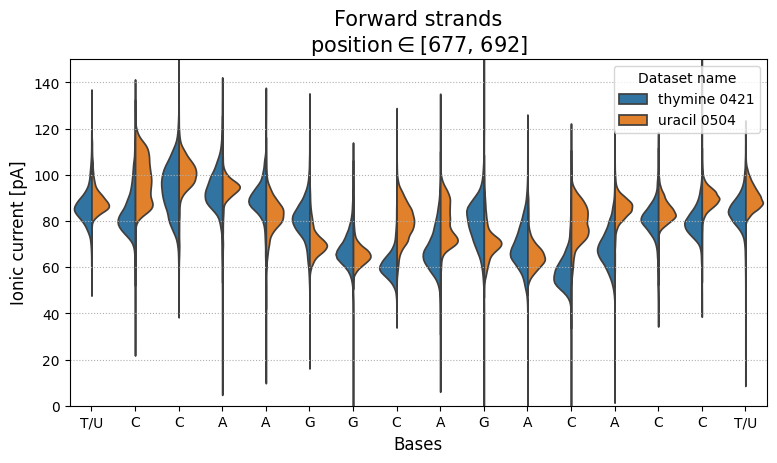

In [11]:
N_left, N_right = 15, 0 # number of left and right neighbors

data_T_fwd = create_df_to_violin_plot(thymine_fwd_strd, 'thymine 0421',
                                      N_left, N_right, searched_position)
data_U_fwd = create_df_to_violin_plot(uracil_fwd_strd, 'uracil 0504', 
                                      N_left, N_right, searched_position, )

fwd_violin_df = pd.concat([data_T_fwd, data_U_fwd], ignore_index=True)

plt.figure(figsize=(9, 4.5))
plt.grid(ls='dotted', axis='y')
sns.violinplot(data=fwd_violin_df, x="Bases", y="IonicCurrent", hue="Dataset name", split=True, density_norm="width", inner=None)
plt.xlabel("Bases", fontsize=FS)
plt.ylabel("Ionic current [pA]", fontsize=FS)
plt.title("Forward strands\nposition"+r"$\in$"+f"[{searched_position-N_left}, {searched_position+N_right}]", fontsize=FS+3)
plt.ylim(0, 150)
labels = p300_ID3_ref[searched_position - N_left: searched_position + N_right + 1]
plt.xticks(ticks=np.arange(N_left+N_right+1), labels=np.where(labels=='T', 'T/U', labels))
plt.savefig(f'figures/violin_fwd_pos={searched_position}_Nleft={N_left}_Nright={N_right}.pdf', bbox_inches='tight')
plt.show()

---
### reversed

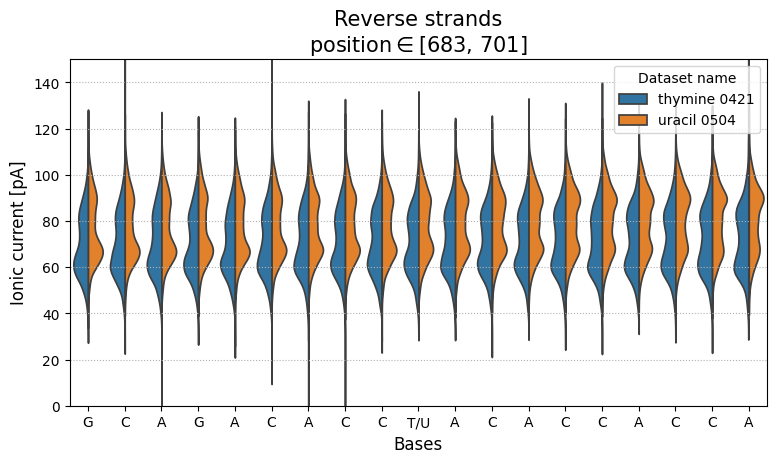

In [12]:
N_left, N_right = 9, 9 # number of left and right neighbors

data_T_rvs = create_df_to_violin_plot(thymine_rvs_strd, 'thymine 0421',
                                      N_left, N_right, searched_position)
data_U_rvs = create_df_to_violin_plot(uracil_rvs_strd, 'uracil 0504',
                                      N_left, N_right, searched_position)

rvs_violin_df = pd.concat([data_T_rvs, data_U_rvs], ignore_index=True)

plt.figure(figsize=(9, 4.5))
plt.grid(ls='dotted', axis='y')
sns.violinplot(data=rvs_violin_df, x="Bases", y="IonicCurrent", hue="Dataset name", split=True, density_norm="width", inner=None)
plt.xlabel("Bases", fontsize=FS)
plt.ylabel("Ionic current [pA]", fontsize=FS)
plt.title("Reverse strands\nposition"+r"$\in$"+f"[{searched_position-N_left}, {searched_position+N_right}]", fontsize=FS+3)
labels = p300_ID3_ref[searched_position - N_left: searched_position + N_right + 1]
plt.xticks(ticks=np.arange(N_left+N_right+1), labels=np.where(labels=='T', 'T/U', labels))
plt.ylim(0, 150)
plt.savefig(f'figures/violin_rvs_pos={searched_position}_Nleft={N_left}_Nright={N_right}.pdf', bbox_inches='tight')
plt.show()

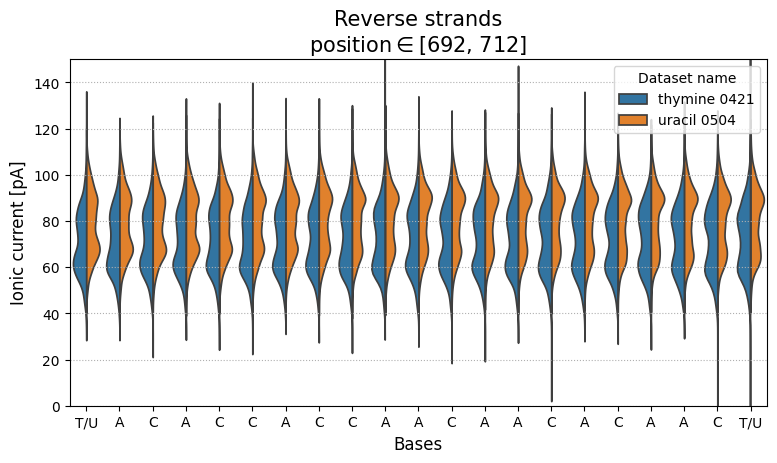

In [13]:
N_left, N_right = 0, 20 # number of left and right neighbors

data_T_rvs = create_df_to_violin_plot(thymine_rvs_strd, 'thymine 0421',
                                      N_left, N_right, searched_position)
data_U_rvs = create_df_to_violin_plot(uracil_rvs_strd, 'uracil 0504',
                                      N_left, N_right, searched_position)

rvs_violin_df = pd.concat([data_T_rvs, data_U_rvs], ignore_index=True)

plt.figure(figsize=(9, 4.5))
plt.grid(ls='dotted', axis='y')
sns.violinplot(data=rvs_violin_df, x="Bases", y="IonicCurrent", hue="Dataset name", split=True, density_norm="width", inner=None)
plt.xlabel("Bases", fontsize=FS)
plt.ylabel("Ionic current [pA]", fontsize=FS)
plt.title("Reverse strands\nposition"+r"$\in$"+f"[{searched_position-N_left}, {searched_position+N_right}]", fontsize=FS+3)
labels = p300_ID3_ref[searched_position - N_left: searched_position + N_right + 1]
plt.xticks(ticks=np.arange(N_left+N_right+1), labels=np.where(labels=='T', 'T/U', labels))
plt.ylim(0, 150)
plt.savefig(f'figures/violin_rvs_pos={searched_position}_Nleft={N_left}_Nright={N_right}.pdf', bbox_inches='tight')
plt.show()

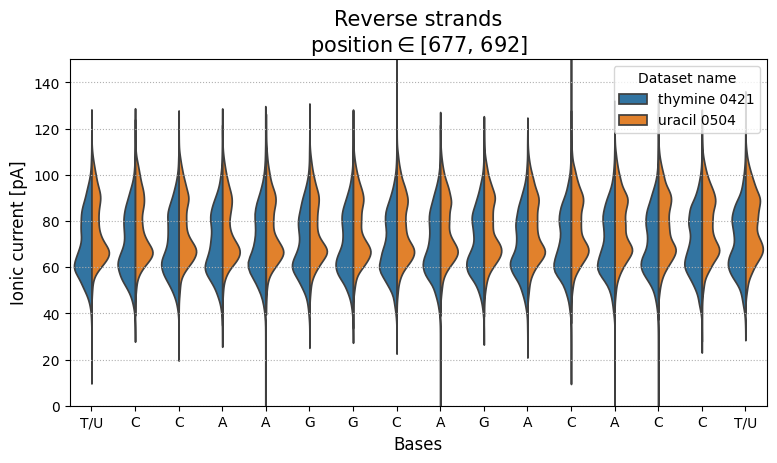

In [14]:
N_left, N_right = 15, 0 # number of left and right neighbors

data_T_rvs = create_df_to_violin_plot(thymine_rvs_strd, 'thymine 0421',
                                      N_left, N_right, searched_position)
data_U_rvs = create_df_to_violin_plot(uracil_rvs_strd, 'uracil 0504',
                                      N_left, N_right, searched_position)

rvs_violin_df = pd.concat([data_T_rvs, data_U_rvs], ignore_index=True)

plt.figure(figsize=(9, 4.5))
plt.grid(ls='dotted', axis='y')
sns.violinplot(data=rvs_violin_df, x="Bases", y="IonicCurrent", hue="Dataset name", split=True, density_norm="width", inner=None)
plt.xlabel("Bases", fontsize=FS)
plt.ylabel("Ionic current [pA]", fontsize=FS)
plt.title("Reverse strands\nposition"+r"$\in$"+f"[{searched_position-N_left}, {searched_position+N_right}]", fontsize=FS+3)
labels = p300_ID3_ref[searched_position - N_left: searched_position + N_right + 1]
plt.xticks(ticks=np.arange(N_left+N_right+1), labels=np.where(labels=='T', 'T/U', labels))
plt.ylim(0, 150)
plt.savefig(f'figures/violin_rvs_pos={searched_position}_Nleft={N_left}_Nright={N_right}.pdf', bbox_inches='tight')
plt.show()

---
# Random other position

In [15]:
find_loneliest_bases_in_seq(p300_ID3_ref, only_nth=95, verbose=True)

The position of the loneliest base 'T': 1059
Distances between the neighborhood: [ 5  5  2 24]
The subsequence:
 ['T' 'G' 'G' 'A' 'A' 'T' 'C' 'T']


In [16]:
searched_position = find_loneliest_bases_in_seq(p300_ID3_ref, only_nth=95)
searched_position 

1059

### forward

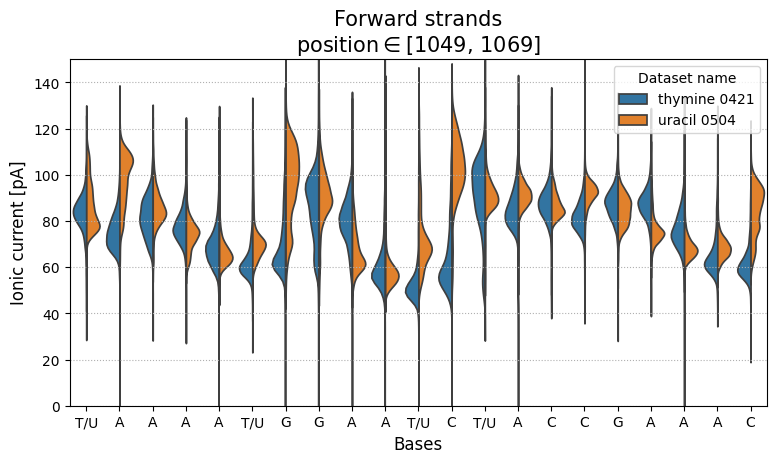

In [17]:
N_left, N_right = 10, 10 # number of left and right neighbors

data_T_fwd = create_df_to_violin_plot(thymine_fwd_strd, 'thymine 0421',
                                      N_left, N_right, searched_position)
data_U_fwd = create_df_to_violin_plot(uracil_fwd_strd, 'uracil 0504', 
                                      N_left, N_right, searched_position, )

fwd_violin_df = pd.concat([data_T_fwd, data_U_fwd], ignore_index=True)

plt.figure(figsize=(9, 4.5))
plt.grid(ls='dotted', axis='y')
sns.violinplot(data=fwd_violin_df, x="Bases", y="IonicCurrent", hue="Dataset name", split=True, density_norm="width", inner=None)
plt.xlabel("Bases", fontsize=FS)
plt.ylabel("Ionic current [pA]", fontsize=FS)
plt.title("Forward strands\nposition"+r"$\in$"+f"[{searched_position-N_left}, {searched_position+N_right}]", fontsize=FS+3)
plt.ylim(0, 150)
labels = p300_ID3_ref[searched_position - N_left: searched_position + N_right + 1]
plt.xticks(ticks=np.arange(N_left+N_right+1), labels=np.where(labels=='T', 'T/U', labels))
plt.savefig(f'figures/violin_fwd_pos={searched_position}_Nleft={N_left}_Nright={N_right}.pdf', bbox_inches='tight')
plt.show()

### reverse

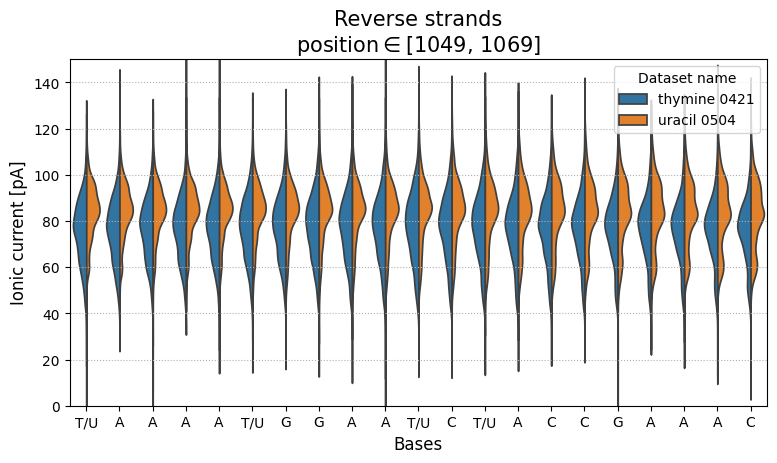

In [18]:
N_left, N_right = 10, 10 # number of left and right neighbors

data_T_rvs = create_df_to_violin_plot(thymine_rvs_strd, 'thymine 0421',
                                      N_left, N_right, searched_position)
data_U_rvs = create_df_to_violin_plot(uracil_rvs_strd, 'uracil 0504',
                                      N_left, N_right, searched_position)

rvs_violin_df = pd.concat([data_T_rvs, data_U_rvs], ignore_index=True)

plt.figure(figsize=(9, 4.5))
plt.grid(ls='dotted', axis='y')
sns.violinplot(data=rvs_violin_df, x="Bases", y="IonicCurrent", hue="Dataset name", split=True, density_norm="width", inner=None)
plt.xlabel("Bases", fontsize=FS)
plt.ylabel("Ionic current [pA]", fontsize=FS)
plt.title("Reverse strands\nposition"+r"$\in$"+f"[{searched_position-N_left}, {searched_position+N_right}]", fontsize=FS+3)
labels = p300_ID3_ref[searched_position - N_left: searched_position + N_right + 1]
plt.xticks(ticks=np.arange(N_left+N_right+1), labels=np.where(labels=='T', 'T/U', labels))
plt.ylim(0, 150)
plt.savefig(f'figures/violin_rvs_pos={searched_position}_Nleft={N_left}_Nright={N_right}.pdf', bbox_inches='tight')
plt.show()